#### 1. Setup

In [1]:
import numpy as np
import pandas as pd

from pathlib import Path

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    roc_auc_score
)

import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")
tf.random.set_seed(42)
np.random.seed(42)


#### 2. Load data

In [2]:
PROC_DIR = Path("../data/processed")

X_train = np.load(PROC_DIR / "X_train_normal.npy")
X_test  = np.load(PROC_DIR / "X_test.npy")
y_test  = np.load(PROC_DIR / "y_test.npy")

print("Train (normal only):", X_train.shape)
print("Test:", X_test.shape)
print("Test label distribution:\n", pd.Series(y_test).value_counts())


Train (normal only): (67343, 118)
Test: (22544, 118)
Test label distribution:
 1    12833
0     9711
Name: count, dtype: int64


#### 3. Autoencoder Architecture

In [3]:
input_dim = X_train.shape[1]

input_layer = Input(shape=(input_dim,))

encoded = Dense(64, activation="relu")(input_layer)
encoded = Dense(32, activation="relu")(encoded)
encoded = Dense(16, activation="relu")(encoded)

decoded = Dense(32, activation="relu")(encoded)
decoded = Dense(64, activation="relu")(decoded)
decoded = Dense(input_dim, activation="sigmoid")(decoded)

autoencoder = Model(inputs=input_layer, outputs=decoded)
autoencoder.compile(
    optimizer="adam",
    loss="mse"
)

autoencoder.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 118)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         7,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 118)            │         7,670 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,550 (80.27 KB)

 Trainable params: 20,550 (80.27 KB)

 Non-trainable params: 0 (0.00 B)

#### 4. Training

In [4]:
early_stop = EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)

history = autoencoder.fit(
    X_train,
    X_train,
    epochs=50,
    batch_size=256,
    validation_split=0.1,
    callbacks=[early_stop],
    shuffle=True,
    verbose=1
)


Epoch 1/50
237/237 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6862 - val_loss: 0.6301
Epoch 2/50
237/237 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5355 - val_loss: 0.6234
Epoch 3/50
237/237 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5308 - val_loss: 0.6223
Epoch 4/50
237/237 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5296 - val_loss: 0.6213
Epoch 5/50
237/237 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5287 - val_loss: 0.6209
Epoch 6/50
237/237 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5282 - val_loss: 0.6186
Epoch 7/50
237/237 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5260 - val_loss: 0.6180
Epoch 8/50
237/237 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5253 - val_loss: 0.6176
Epoch 9/50
237/237 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5249 - val_loss: 0.6171
Epoch 10/50
237/237 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5245 - val_loss: 0.6163
Epoch 11/50
237/237 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5239 - val_loss: 0.6161
Epoch 12/50
237/237 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

#### 5. Training loss visualization

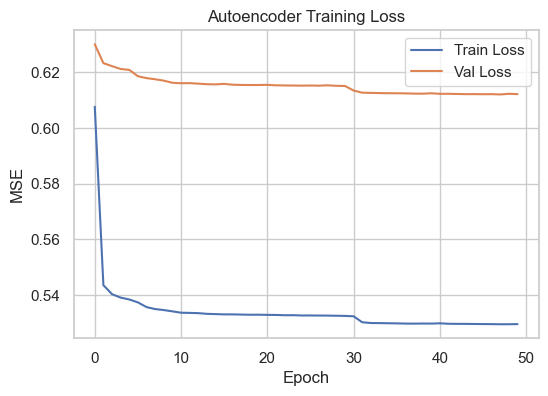

In [5]:
plt.figure(figsize=(6,4))
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.title("Autoencoder Training Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.legend()
plt.show()


#### 6. Reconstruction Error on Train

In [6]:
# Reconstruction error on TRAIN (normal only)
X_train_pred = autoencoder.predict(X_train)

train_recon_error = np.mean(
    np.square(X_train - X_train_pred),
    axis=1
)

pd.Series(train_recon_error).describe()


2105/2105 ━━━━━━━━━━━━━━━━━━━━ 1s 463us/step


count    67343.000000
mean         0.537773
std          5.587589
min          0.012206
25%          0.020115
50%          0.103197
75%          0.223561
max        867.686462
dtype: float64

#### 7. Anomaly Threshold

In [7]:
threshold = np.percentile(train_recon_error, 90)
threshold


0.9483604788780213

#### 8. Reconstruction Error on Test

In [8]:
X_test_pred = autoencoder.predict(X_test)

test_recon_error = np.mean(
    np.square(X_test - X_test_pred),
    axis=1
)

pd.Series(test_recon_error).describe()


705/705 ━━━━━━━━━━━━━━━━━━━━ 0s 478us/step


count    22544.000000
mean         6.247746
std         31.225983
min          0.013004
25%          0.032708
50%          1.154680
75%          3.120212
max        588.753906
dtype: float64

#### 9. Predict Anomaly

In [9]:
y_pred = (test_recon_error > threshold).astype(int)

print("Predicted anomalies:")
print(pd.Series(y_pred).value_counts())


Predicted anomalies:
1    11997
0    10547
Name: count, dtype: int64


#### 10. Evaluation

In [12]:
print("Confusion Matrix:\n")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))

roc_auc = roc_auc_score(y_test, test_recon_error)
print("ROC-AUC (AE anomaly score):", roc_auc)



Confusion Matrix:

[[ 8815   896]
 [ 1732 11101]]

Classification Report:

              precision    recall  f1-score   support

           0       0.84      0.91      0.87      9711
           1       0.93      0.87      0.89     12833

    accuracy                           0.88     22544
   macro avg       0.88      0.89      0.88     22544
weighted avg       0.89      0.88      0.88     22544

ROC-AUC (AE anomaly score): 0.9552342083068119


#### 11. Reconstruction Error distribution

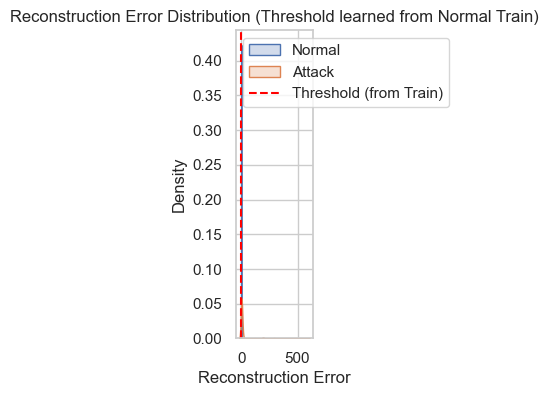

In [13]:
plt.figure(figsize=(1,4))
sns.kdeplot(test_recon_error[y_test == 0], label="Normal", fill=True)
sns.kdeplot(test_recon_error[y_test == 1], label="Attack", fill=True)
plt.axvline(threshold, color="red", linestyle="--", label="Threshold (from Train)")
plt.title("Reconstruction Error Distribution (Threshold learned from Normal Train)")
plt.xlabel("Reconstruction Error")
plt.legend()
plt.show()


#### 12. Summary
A fully connected autoencoder was trained exclusively on normal network traffic to learn the underlying normal behavior. During inference, anomalous samples exhibited significantly higher reconstruction errors due to their deviation from learned patterns. The model achieved a high ROC-AUC score, demonstrating strong anomaly ranking capability. This confirms the effectiveness of deep unsupervised learning for intrusion detection without relying on attack signatures.
